In [1]:
import sqlite3
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# connecting to db
conn = sqlite3.connect('data/noshow.db')

# retrieving the data
query = "SELECT * FROM noshow"

df = pd.read_sql(query, conn)
conn.close()

print(df.shape)
print(df.info())
print(df.head(20))

(119391, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119391 entries, 0 to 119390
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   booking_id      119391 non-null  int64  
 1   no_show         119390 non-null  float64
 2   branch          119390 non-null  object 
 3   booking_month   119390 non-null  object 
 4   arrival_month   119390 non-null  object 
 5   arrival_day     119390 non-null  float64
 6   checkout_month  119390 non-null  object 
 7   checkout_day    119390 non-null  float64
 8   country         119390 non-null  object 
 9   first_time      119390 non-null  object 
 10  room            97778 non-null   object 
 11  price           94509 non-null   object 
 12  platform        119390 non-null  object 
 13  num_adults      119390 non-null  object 
 14  num_children    119390 non-null  float64
dtypes: float64(4), int64(1), object(10)
memory usage: 13.7+ MB
None
    booking_id  no_show  

In [3]:
# 2) Checking missing values and NaN

missing_values = df.isnull().sum()
missing_percentage = 100 * df.isnull().sum() / len(df)

# combining count and percentage into a single DataFrame
missing_table = pd.concat([missing_values, missing_percentage], 
                          axis=1, keys=['Missing Count', 'Missing Percentage'])

print(missing_table)

                Missing Count  Missing Percentage
booking_id                  0            0.000000
no_show                     1            0.000838
branch                      1            0.000838
booking_month               1            0.000838
arrival_month               1            0.000838
arrival_day                 1            0.000838
checkout_month              1            0.000838
checkout_day                1            0.000838
country                     1            0.000838
first_time                  1            0.000838
room                    21613           18.102705
price                   24882           20.840767
platform                    1            0.000838
num_adults                  1            0.000838
num_children                1            0.000838


In [4]:
# Data cleaning: Standardizing data input before inputing missing values


# replacing all num_adults text values into numeric values
num_map = {'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5}
df['num_adults'] = df['num_adults'].replace(num_map)

# Converting num_adults object > numeric type. 
# Any values that can't be converted will be NaN with errors='coerce'
df['num_adults'] = pd.to_numeric(df['num_adults'], errors='coerce')

# Numeric > integer type for whole numbers
df['num_adults'] = df['num_adults'].astype('Int64')



df['num_children'] = pd.to_numeric(df['num_children'], errors='coerce')

# round it off to the nearest integer just in case there are non-whole values in the decimals
df['num_children'] = np.round(df['num_children'])
df['num_children'] = df['num_children'].astype('Int64')


print(df[['num_adults', 'num_children']].head(10).to_string(index=True))

   num_adults  num_children
0           1             0
1           2             0
2           1             0
3           1             0
4           1             0
5           2             2
6           1             1
7           2             1
8           2             1
9           1             1


In [5]:
# Cleaning the price data by removing the currency symbols and converting it into float

# Replacing None with NaN
df['price'] = df['price'].replace('None', np.nan)

# convert to string first as base to remove all non-numeric characters
df['price'] = df['price'].astype(str).str.replace(r'[^\d.]', '', regex=True)

# now convert to float, if there are errors, replace them with NaN
df['price'] = pd.to_numeric(df['price'], errors='coerce')


# convert the price to a single currency, SGD. 1 USD = 1.35 SGD
df['price_sgd'] = df.apply(
    lambda row: row['price'] * 1.35 if 'USD' in str(row['price']) else row['price'], 
    axis=1
)

In [6]:
# choose features for 'room' imputation. Plan is to impute 'room' missing values, then using it to predict 'price'
room_features = ['price_sgd', 'num_adults', 'num_children', 'branch']

# split the data
known_rooms = df.dropna(subset=['room']).copy()
missing_rooms = df[df['room'].isnull()].copy()

# prepare the features and target for the model
X = known_rooms[room_features].copy()
y = known_rooms['room'].copy()

# check for any remaining NaN values in X
print("NaN values in X:")
print(X.isna().sum())

NaN values in X:
price_sgd       24881
num_adults          0
num_children        0
branch              0
dtype: int64


In [8]:
# Plan is to temporarily remove any rows with NaN values in 'price_sgd'
# And after using the rest of the data to predict 'room', go back to imputing 'price_sgd'

# remove any rows with NaN values for 'price_sgd' temporarily
df_temp = df.dropna(subset=['price_sgd'])

# Separate known and missing rooms
known_rooms = df_temp.dropna(subset=['room'])



# separate numeric and categorical features
numeric_features = ['price_sgd', 'num_adults', 'num_children']
categorical_features = ['branch']

# Replace None with NaN in 'branch' column
missing_rooms['branch'] = missing_rooms['branch'].replace({None: np.nan})

# create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

                
# fit and transform the data
X = preprocessor.fit_transform(X)

# get feature names after preprocessing
feature_names = (
    numeric_features + 
    preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(['branch']).tolist()
)

# convert back to DataFrame 
X = pd.DataFrame(X, columns=feature_names)

# encode target variable
le_room = LabelEncoder()
y = le_room.fit_transform(y)

# training a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# prepare the data for prediction
X_predict = missing_rooms[room_features]
X_predict = preprocessor.transform(X_predict)
X_predict = pd.DataFrame(X_predict, columns=feature_names)

# predict room types
predicted_rooms = le_room.inverse_transform(model.predict(X_predict))

# fill in predicted room types
df.loc[df['room'].isnull(), 'room'] = predicted_rooms

# print the number of null values in room column
null_count = df['room'].isnull().sum()
print(f"Number of null values in 'room' column: {null_count}")

# Print value counts of room types
print("\nValue counts of room types:")
print(df['room'].value_counts())

Number of null values in 'room' column: 0

Value counts of room types:
room
King               86048
Single             19182
Queen              13232
President Suite      929
Name: count, dtype: int64


In [9]:
# using room to predict price for imputation
price_features = ['room', 'num_adults', 'num_children', 'branch']

known_prices = df.dropna(subset=['price_sgd']).copy()
missing_prices = df[df['price_sgd'].isnull()].copy()

# preparing features and target for model
X_price = known_prices[price_features]
y_price = known_prices['price_sgd']

# creating preprocessor for price imputation model
price_preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), ['num_adults', 'num_children']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['room', 'branch'])
 ])

# training Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

price_model = Pipeline([
    ('preprocessor', price_preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

price_model.fit(X_price, y_price)

# predict missing prices
X_price_predict = missing_prices[price_features]
predicted_prices = price_model.predict(X_price_predict)

# fill in predicted prices
df.loc[df['price_sgd'].isnull(), 'price_sgd'] = predicted_prices

# check results
print("Number of missing prices after imputation:", df['price_sgd'].isnull().sum())
print("\nSummary statistics of imputed prices:")
print(df['price_sgd'].describe())

Number of missing prices after imputation: 0

Summary statistics of imputed prices:
count    119391.000000
mean        821.902918
std         257.900561
min         292.010000
25%         646.554473
50%         779.809288
75%         951.835000
max        2099.960000
Name: price_sgd, dtype: float64


In [10]:
# current status of data check before examining outliers and relationships between variables
print(df.shape)
print(df.info())
print(df.head(20))

(119391, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119391 entries, 0 to 119390
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   booking_id      119391 non-null  int64  
 1   no_show         119390 non-null  float64
 2   branch          119390 non-null  object 
 3   booking_month   119390 non-null  object 
 4   arrival_month   119390 non-null  object 
 5   arrival_day     119390 non-null  float64
 6   checkout_month  119390 non-null  object 
 7   checkout_day    119390 non-null  float64
 8   country         119390 non-null  object 
 9   first_time      119390 non-null  object 
 10  room            119391 non-null  object 
 11  price           94509 non-null   float64
 12  platform        119390 non-null  object 
 13  num_adults      119390 non-null  Int64  
 14  num_children    119390 non-null  Int64  
 15  price_sgd       119391 non-null  float64
dtypes: Int64(2), float64(5), int64(1), object(8

In [11]:
# dealing with NaN values
nan_count = df.isna().sum()
print("NaN count in each column:")
print(nan_count)

NaN count in each column:
booking_id            0
no_show               1
branch                1
booking_month         1
arrival_month         1
arrival_day           1
checkout_month        1
checkout_day          1
country               1
first_time            1
room                  0
price             24882
platform              1
num_adults            1
num_children          1
price_sgd             0
dtype: int64


In [12]:
# dropping 'price' since we already have 'price_sgd'
df = df.drop('price', axis=1)

# imputing NaN with median for numeric variables
numeric_columns = ['no_show', 'arrival_day', 'checkout_day', 'price_sgd', 'num_adults', 'num_children']
for col in numeric_columns:
    df[col] = df[col].fillna(df[col].median())

# imputing NaN with mode for categorical variables
categorical_columns = ['branch', 'country', 'room', 'platform', 'first_time', 'booking_month', 'arrival_month', 'checkout_month']
for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

new_nan_count = df.isna().sum()
print("NaN count after imputation")
print(new_nan_count)

NaN count after imputation
booking_id        0
no_show           0
branch            0
booking_month     0
arrival_month     0
arrival_day       0
checkout_month    0
checkout_day      0
country           0
first_time        0
room              0
platform          0
num_adults        0
num_children      0
price_sgd         0
dtype: int64


In [13]:
# 3) DATATYPE CONVERSION

# convert all floats to int, except for price which might require decimal spaces
df['no_show'] = df['no_show'].astype('Int64')
df['arrival_day'] = df['arrival_day'].astype('Int64')
df['checkout_day'] = df['checkout_day'].astype('Int64')

# convert month columns to ordinal categorical
month_columns = ['booking_month', 'arrival_month', 'checkout_month']
month_order =['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for col in month_columns:
    df[col] = pd.Categorical(df[col], categories=month_order, ordered=True)

# binary encoding first_time to integer
df['first_time'] = df['first_time'].map({'Yes': 1, 'No': 0}).astype(int)

# converting object columns to category
for col in ['branch', 'country', 'room', 'platform']:
    df[col] = df[col].astype('category')

print(df.dtypes)

booking_id           int64
no_show              Int64
branch            category
booking_month     category
arrival_month     category
arrival_day          Int64
checkout_month    category
checkout_day         Int64
country           category
first_time           int64
room              category
platform          category
num_adults           Int64
num_children         Int64
price_sgd          float64
dtype: object


In [14]:
# 4) FEATURE ENGINEERING
# creating variable for the difference between the 'booking_month' and the 'arrival_month', as it could be significant
# changing month names to numbers for both 'booking_month' and 'arrival_month'
# Drop rows with NaN values
df = df.dropna()

month_to_num = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

df['booking_month_num'] = df['booking_month'].map(month_to_num).astype(int)
df['arrival_month_num'] = df['arrival_month'].map(month_to_num).astype(int)

# calculating the difference
df['month_difference'] = (df['arrival_month_num'] - df['booking_month_num']) % 12

print(df['month_difference'])
print(df[['booking_month', 'arrival_month', 'month_difference']].head(20))

0          7
1          3
2         11
3          1
4          3
          ..
119386     7
119387     9
119388     6
119389     0
119390     4
Name: month_difference, Length: 117778, dtype: int64
   booking_month arrival_month  month_difference
0       November          June                 7
1         August      November                 3
2          March      February                11
3      September       October                 1
4          March          June                 3
5       November     September                10
6       November       October                11
7           July      November                 4
8        January          June                 5
9        October         March                 5
10       October         March                 5
11         March          June                 3
12         March      November                 8
13          June         March                 9
14          July           May                10
15      December    

In [15]:
# calculating how long the guest stays as a variable
from datetime import datetime

# Function to create a date object (we'll use a fixed year)
def create_date(month, day, year=2023):
    month_num = month_to_num[month]
    try:
        return datetime(year, month_num, day)
    except ValueError:
        # Return None for invalid dates
        return None

# Create date objects for arrival and checkout
df['arrival_date'] = df.apply(lambda row: create_date(row['arrival_month'], row['arrival_day']), axis=1)
df['checkout_date'] = df.apply(lambda row: create_date(row['checkout_month'], row['checkout_day']), axis=1)

# Identify rows with invalid dates
invalid_arrival = df[df['arrival_date'].isnull()]
invalid_checkout = df[df['checkout_date'].isnull()]

# Remove rows with invalid dates
df = df.dropna(subset=['arrival_date', 'checkout_date'])

# Calculate stay length
df['stay_length'] = (df['checkout_date'] - df['arrival_date']).dt.days

# Handle cases where checkout is in the next year
df.loc[df['stay_length'] < 0, 'stay_length'] += 365

print(df[['arrival_day', 'checkout_day', 'stay_length']])

        arrival_day  checkout_day  stay_length
0                25            27            2
1                28            29            1
2                 7            11            4
3                 1             3            2
4                20            24            4
...             ...           ...          ...
119386            3             5            2
119387           30             3            4
119388           31             1            1
119389           25            27            2
119390           18            26            8

[112070 rows x 3 columns]


In [16]:
# 5) ENCODING
# checking to see which needs to be encoded
print(df.info())
print(df.head(20))

<class 'pandas.core.frame.DataFrame'>
Index: 112070 entries, 0 to 119390
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   booking_id         112070 non-null  int64         
 1   no_show            112070 non-null  Int64         
 2   branch             112070 non-null  category      
 3   booking_month      112070 non-null  category      
 4   arrival_month      112070 non-null  category      
 5   arrival_day        112070 non-null  Int64         
 6   checkout_month     112070 non-null  category      
 7   checkout_day       112070 non-null  Int64         
 8   country            112070 non-null  category      
 9   first_time         112070 non-null  int64         
 10  room               112070 non-null  category      
 11  platform           112070 non-null  category      
 12  num_adults         112070 non-null  Int64         
 13  num_children       112070 non-null  Int64        

In [17]:
# dropping categories that have been label encoded beforehand
# realized I missed out on checkout_month_num here. But it does seem less relevant anw
df = df.drop(['booking_month', 'arrival_month', 'checkout_month'], axis=1)
print(df.dtypes)

booking_id                    int64
no_show                       Int64
branch                     category
arrival_day                   Int64
checkout_day                  Int64
country                    category
first_time                    int64
room                       category
platform                   category
num_adults                    Int64
num_children                  Int64
price_sgd                   float64
booking_month_num             int64
arrival_month_num             int64
month_difference              int64
arrival_date         datetime64[ns]
checkout_date        datetime64[ns]
stay_length                   int64
dtype: object


In [18]:
# checking amount of unique values to see if its high cardinality
print("Hotel branch:")
print(df['branch'].unique())

print("Countries:")
print(df['country'].unique())

print("Room types:")
print(df['room'].unique())

print("Platform booking:")
print(df['platform'].unique())

Hotel branch:
['Changi', 'Orchard']
Categories (2, object): ['Changi', 'Orchard']
Countries:
['Singapore', 'Indonesia', 'India', 'China', 'Australia', 'Japan', 'Malaysia']
Categories (7, object): ['Australia', 'China', 'India', 'Indonesia', 'Japan', 'Malaysia', 'Singapore']
Room types:
['Single', 'King', 'Queen', 'President Suite']
Categories (4, object): ['King', 'President Suite', 'Queen', 'Single']
Platform booking:
['Website', 'Agent', 'Email', 'Phone']
Categories (4, object): ['Agent', 'Email', 'Phone', 'Website']


In [19]:
# using one-hot encoding for it all since its not a lot of unique values
columns_to_encode = ['branch', 'country', 'room', 'platform']

# initialize the one-hot encoder from sklearn, previously imported
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# fit and transform the selected columns
encoded_columns = onehot_encoder.fit_transform(df[columns_to_encode])

# getting the new column names
new_column_names = onehot_encoder.get_feature_names_out(columns_to_encode)

# creating new dataframe with encoded columns and concatenating it with original df
encoded_df = pd.DataFrame(encoded_columns, columns=new_column_names, index=df.index)
df_encoded = pd.concat([df.drop(columns=columns_to_encode), encoded_df], axis=1)

print(df_encoded.head(10))
print(df_encoded.info())

   booking_id  no_show  arrival_day  checkout_day  first_time  num_adults  \
0     94113.0        0           25            27         1.0           1   
1     86543.0        0           28            29         1.0           2   
2     75928.0        0            7            11         1.0           1   
3     66947.0        1            1             3         1.0           1   
4    106390.0        0           20            24         1.0           1   
5     55212.0        0           12            13         1.0           2   
6     42322.0        0           15            16         1.0           1   
7     23137.0        0           18            19         1.0           2   
8    109456.0        1           27            28         1.0           2   
9     31117.0        0           22            24         1.0           1   

   num_children    price_sgd  booking_month_num  arrival_month_num  ...  \
0             0   492.980000               11.0                6.0  ...   
1 

In [20]:
# 6) OUTLIERS
# z-score and IQR to detect outliers, choosing numerical features
from scipy import stats

def detect_outliers_zscore(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    return z_scores > threshold

outliers_price = detect_outliers_zscore(df_encoded['price_sgd'])
outliers_month_diff = detect_outliers_zscore(df_encoded['month_difference'])
outliers_stay = detect_outliers_zscore(df_encoded['stay_length'])

def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

outliers_price_iqr = detect_outliers_iqr(df_encoded['price_sgd'])
outliers_month_diff_iqr = detect_outliers_iqr(df_encoded['month_difference'])
outliers_stay_iqr = detect_outliers_iqr(df_encoded['stay_length'])

print("Z-score method:")
print(f"Price outliers: {outliers_price.sum()}")
print(f"Month difference outliers: {outliers_month_diff.sum()}")
print(f"Stay length outliers: {outliers_stay.sum()}")

print("\nIQR method:")
print(f"Price outliers: {outliers_price_iqr.sum()}")
print(f"Month difference outliers: {outliers_month_diff_iqr.sum()}")
print(f"Stay length outliers: {outliers_stay_iqr.sum()}")

Z-score method:
Price outliers: 0
Month difference outliers: 0
Stay length outliers: 0

IQR method:
Price outliers: 3269
Month difference outliers: 0
Stay length outliers: 8200


In [21]:
print("NaN values in price_sgd:", df_encoded['price_sgd'].isna().sum())
print("NaN values in stay_length:", df_encoded['stay_length'].isna().sum())
print("Infinite values in price_sgd:", np.isinf(df_encoded['price_sgd']).sum())
print("Infinite values in stay_length:", np.isinf(df_encoded['stay_length']).sum())

NaN values in price_sgd: 7321
NaN values in stay_length: 7321
Infinite values in price_sgd: 0
Infinite values in stay_length: 0


In [22]:
total_rows = len(df_encoded)
nan_percentage = (7321 / total_rows) * 100
print(f"Percentage of NaN values: {nan_percentage:.2f}%")

Percentage of NaN values: 6.13%


In [23]:
def remove_outliers_zscore(data, threshold=3):
    # Remove NaN values
    data_clean = data.dropna()
    
    # Calculate z-scores
    z_scores = np.abs(stats.zscore(data_clean))
    
    # Create a boolean mask of values to keep
    mask = z_scores < threshold
    
    print(f"Number of data points within threshold: {mask.sum()}")
    print(f"Total data points (excluding NaN): {len(data_clean)}")
    
    return data_clean[mask]

# Apply to the data
price_no_outliers = remove_outliers_zscore(df_encoded['price_sgd'])
stay_length_no_outliers = remove_outliers_zscore(df_encoded['stay_length'])

# Print summary statistics
print("\nPrice summary:")
print("Original (including NaN):", df_encoded['price_sgd'].describe())
print("After removing outliers:", price_no_outliers.describe())

print("\nStay length summary:")
print("Original (including NaN):", df_encoded['stay_length'].describe())
print("After removing outliers:", stay_length_no_outliers.describe())

# Calculate percentage of data removed (excluding NaN values from original)
price_removed = 1 - len(price_no_outliers) / df_encoded['price_sgd'].notna().sum()
stay_removed = 1 - len(stay_length_no_outliers) / df_encoded['stay_length'].notna().sum()

print(f"\nPercentage of non-NaN price data removed: {price_removed*100:.2f}%")
print(f"Percentage of non-NaN stay length data removed: {stay_removed*100:.2f}%")

Number of data points within threshold: 111533
Total data points (excluding NaN): 112070
Number of data points within threshold: 110018
Total data points (excluding NaN): 112070

Price summary:
Original (including NaN): count    112070.000000
mean        821.656576
std         257.707497
min         292.010000
25%         646.554473
50%         779.809288
75%         951.635000
max        2099.960000
Name: price_sgd, dtype: float64
After removing outliers: count    111533.000000
mean        816.603117
std         247.606627
min         292.010000
25%         646.554473
50%         779.809288
75%         949.320000
max        1532.690000
Name: price_sgd, dtype: float64

Stay length summary:
Original (including NaN): count    112070.000000
mean          2.109896
std           2.423157
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max         364.000000
Name: stay_length, dtype: float64
After removing outliers: count    110018.000000
mean     

In [24]:
# for outlier free data
df_encoded['price_sgd_clean'] = df_encoded['price_sgd']
df_encoded.loc[df_encoded['price_sgd'].notna(), 'price_sgd_clean'] = price_no_outliers

df_encoded['stay_length_clean'] = df_encoded['stay_length']
df_encoded.loc[df_encoded['stay_length'].notna(), 'stay_length_clean'] = stay_length_no_outliers

print(df_encoded.dtypes)
print(df_encoded.info)

booking_id                     float64
no_show                          Int64
arrival_day                      Int64
checkout_day                     Int64
first_time                     float64
num_adults                       Int64
num_children                     Int64
price_sgd                      float64
booking_month_num              float64
arrival_month_num              float64
month_difference               float64
arrival_date            datetime64[ns]
checkout_date           datetime64[ns]
stay_length                    float64
branch_Changi                  float64
branch_Orchard                 float64
branch_None                    float64
country_Australia              float64
country_China                  float64
country_India                  float64
country_Indonesia              float64
country_Japan                  float64
country_Malaysia               float64
country_Singapore              float64
country_None                   float64
room_King                

In [25]:
# dropping stay_length and price_sgd since we have the clean columns
df_encoded = df_encoded.drop(['price_sgd', 'stay_length'], axis=1)
print(df_encoded.info)

<bound method DataFrame.info of         booking_id  no_show  arrival_day  checkout_day  first_time  \
0          94113.0        0           25            27         1.0   
1          86543.0        0           28            29         1.0   
2          75928.0        0            7            11         1.0   
3          66947.0        1            1             3         1.0   
4         106390.0        0           20            24         1.0   
...            ...      ...          ...           ...         ...   
119346         NaN     <NA>         <NA>          <NA>         NaN   
119349         NaN     <NA>         <NA>          <NA>         NaN   
119371         NaN     <NA>         <NA>          <NA>         NaN   
119374         NaN     <NA>         <NA>          <NA>         NaN   
119378         NaN     <NA>         <NA>          <NA>         NaN   

        num_adults  num_children  booking_month_num  arrival_month_num  \
0                1             0               11.0  

In [26]:
# Calculate the percentage of NaN values for each column
nan_percentage = (df_encoded.isnull().sum() / len(df_encoded)) * 100
print(nan_percentage)


booking_id              6.131953
no_show                 6.131953
arrival_day             6.131953
checkout_day            6.131953
first_time              6.131953
num_adults              6.131953
num_children            6.131953
booking_month_num       6.131953
arrival_month_num       6.131953
month_difference        6.131953
arrival_date            6.131953
checkout_date           6.131953
branch_Changi           0.000000
branch_Orchard          0.000000
branch_None             0.000000
country_Australia       0.000000
country_China           0.000000
country_India           0.000000
country_Indonesia       0.000000
country_Japan           0.000000
country_Malaysia        0.000000
country_Singapore       0.000000
country_None            0.000000
room_King               0.000000
room_President Suite    0.000000
room_Queen              0.000000
room_Single             0.000000
room_None               0.000000
platform_Agent          0.000000
platform_Email          0.000000
platform_P

In [27]:
# Identify columns with NaN values, excluding 'booking_id'
columns_with_nan = df_encoded.columns[df_encoded.isnull().any()].tolist()
columns_with_nan = [col for col in columns_with_nan if col != 'booking_id']

# Impute median for these columns
for column in columns_with_nan:
    if df_encoded[column].dtype in ['int64', 'float64', 'Int64']:  # For numeric columns
        median_value = df_encoded[column].median()
        df_encoded[column] = df_encoded[column].fillna(median_value)
    elif pd.api.types.is_object_dtype(df_encoded[column]):  # For categorical columns
        mode_value = df_encoded[column].mode()[0]
        df_encoded[column] = df_encoded[column].fillna(mode_value)

# Verify that NaNs have been handled
print(df_encoded.isnull().sum())

# Check the first few rows to see the effect
print(df_encoded.head())

booking_id              7321
no_show                    0
arrival_day                0
checkout_day               0
first_time                 0
num_adults                 0
num_children               0
booking_month_num          0
arrival_month_num          0
month_difference           0
arrival_date            7321
checkout_date           7321
branch_Changi              0
branch_Orchard             0
branch_None                0
country_Australia          0
country_China              0
country_India              0
country_Indonesia          0
country_Japan              0
country_Malaysia           0
country_Singapore          0
country_None               0
room_King                  0
room_President Suite       0
room_Queen                 0
room_Single                0
room_None                  0
platform_Agent             0
platform_Email             0
platform_Phone             0
platform_Website           0
platform_None              0
price_sgd_clean            0
stay_length_cl

In [28]:
# dropping unnecessary rows
df_encoded = df_encoded.drop(['booking_id', 'arrival_day', 'checkout_day'], axis=1)

In [29]:
# imputing median values for arrival_date and checkout_date

# calculating the median dates 
median_arrival = df_encoded['arrival_date'].median()
median_checkout = df_encoded['checkout_date'].median()

# imputing median values
df_encoded['arrival_date'] = df_encoded['arrival_date'].fillna(median_arrival)
df_encoded['checkout_date'] = df_encoded['checkout_date'].fillna(median_checkout)

# checking again for NaN
nan_counts = df_encoded.isnull().sum()
print(nan_counts)

no_show                 0
first_time              0
num_adults              0
num_children            0
booking_month_num       0
arrival_month_num       0
month_difference        0
arrival_date            0
checkout_date           0
branch_Changi           0
branch_Orchard          0
branch_None             0
country_Australia       0
country_China           0
country_India           0
country_Indonesia       0
country_Japan           0
country_Malaysia        0
country_Singapore       0
country_None            0
room_King               0
room_President Suite    0
room_Queen              0
room_Single             0
room_None               0
platform_Agent          0
platform_Email          0
platform_Phone          0
platform_Website        0
platform_None           0
price_sgd_clean         0
stay_length_clean       0
dtype: int64


In [30]:
print(df_encoded.head(10))

   no_show  first_time  num_adults  num_children  booking_month_num  \
0        0         1.0           1             0               11.0   
1        0         1.0           2             0                8.0   
2        0         1.0           1             0                3.0   
3        1         1.0           1             0                9.0   
4        0         1.0           1             0                3.0   
5        0         1.0           2             2               11.0   
6        0         1.0           1             1               11.0   
7        0         1.0           2             1                7.0   
8        1         1.0           2             1                1.0   
9        0         1.0           1             1               10.0   

   arrival_month_num  month_difference arrival_date checkout_date  \
0                6.0               7.0   2023-06-25    2023-06-27   
1               11.0               3.0   2023-11-28    2023-11-29   
2          

In [31]:
# 7) SCALING
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Define columns to scale
columns_to_scale = ['num_adults', 'num_children', 'booking_month_num', 'arrival_month_num', 'month_difference', 'price_sgd_clean', 'stay_length_clean']

# Create new column names for scaled versions
scaled_columns = [f"{col}_scaled" for col in columns_to_scale]

# Apply scaling and create new columns
df_encoded[scaled_columns] = scaler.fit_transform(df_encoded[columns_to_scale])

# Print the first few rows of the dataframe to verify
print(df_encoded.head(10))

   no_show  first_time  num_adults  num_children  booking_month_num  \
0        0         1.0           1             0               11.0   
1        0         1.0           2             0                8.0   
2        0         1.0           1             0                3.0   
3        1         1.0           1             0                9.0   
4        0         1.0           1             0                3.0   
5        0         1.0           2             2               11.0   
6        0         1.0           1             1               11.0   
7        0         1.0           2             1                7.0   
8        1         1.0           2             1                1.0   
9        0         1.0           1             1               10.0   

   arrival_month_num  month_difference arrival_date checkout_date  \
0                6.0               7.0   2023-06-25    2023-06-27   
1               11.0               3.0   2023-11-28    2023-11-29   
2          

In [32]:
# 8) CORRELATION ANALYSIS
# figuring out which columns have a strong relationship with no_show (target variable)
# Select all columns except 'no_show'
feature_columns = [col for col in df_encoded.columns if col != 'no_show']

# Calculate correlations with 'no_show'
correlations_with_no_show = df_encoded[feature_columns].corrwith(df_encoded['no_show'])

# Sort correlations by absolute value
correlations_sorted = correlations_with_no_show.abs().sort_values(ascending=False)

print("Correlations with 'no_show':")
print(correlations_sorted)

Correlations with 'no_show':
country_China               0.316489
branch_Changi               0.129372
branch_Orchard              0.129360
country_India               0.115536
country_Japan               0.114729
country_Australia           0.109644
country_Indonesia           0.105251
month_difference_scaled     0.085085
month_difference            0.085085
first_time                  0.075822
num_adults                  0.053099
num_adults_scaled           0.053099
room_King                   0.049615
price_sgd_clean             0.045910
price_sgd_clean_scaled      0.045910
country_Singapore           0.045767
room_Single                 0.039809
room_Queen                  0.034227
stay_length_clean_scaled    0.033771
stay_length_clean           0.033771
num_children                0.011635
num_children_scaled         0.011635
checkout_date               0.010724
arrival_date                0.008616
platform_Email              0.005635
country_Malaysia            0.004876
room_Pres

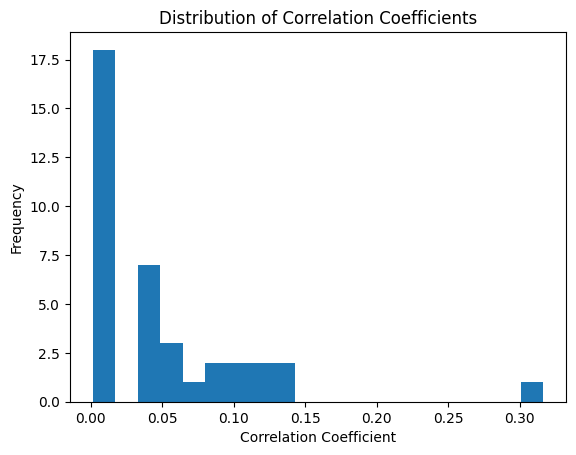

Analysis of natural breakpoints in correlation value
Weak correlation: 0-0.05
Moderate correlation: 0.05-0.10
Strong correlation: >0.10


In [33]:
# visualizing where the natural breakpoint in correlation value is to determine threshold
import matplotlib.pyplot as plt
plt.hist(correlations_sorted, bins=20)
plt.title('Distribution of Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.show()

print("""
Analysis of natural breakpoints in correlation value
Weak correlation: 0-0.05
Moderate correlation: 0.05-0.10
Strong correlation: >0.10
""".strip())

In [34]:
# filter correlations above the threshold
high_corr_features = correlations_sorted[abs(correlations_sorted) >= 0.05]

# list of column names to be kept
columns_to_keep = high_corr_features.index.tolist()

# adding no_show to the list
if 'no_show' not in columns_to_keep:
    columns_to_keep.append('no_show')

final_df = df_encoded[columns_to_keep]

print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 119391 entries, 0 to 119378
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   country_China            119391 non-null  float64
 1   branch_Changi            119391 non-null  float64
 2   branch_Orchard           119391 non-null  float64
 3   country_India            119391 non-null  float64
 4   country_Japan            119391 non-null  float64
 5   country_Australia        119391 non-null  float64
 6   country_Indonesia        119391 non-null  float64
 7   month_difference_scaled  119391 non-null  float64
 8   month_difference         119391 non-null  float64
 9   first_time               119391 non-null  float64
 10  num_adults               119391 non-null  Int64  
 11  num_adults_scaled        119391 non-null  float64
 12  no_show                  119391 non-null  Int64  
dtypes: Int64(2), float64(11)
memory usage: 13.0 MB
None
